In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model

# reflect the tables
Base = automap_base()
Base.prepare(autoload_with=engine)
Station = Base.classes.station
Measurement = Base.classes.measurement

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
latest_date = session.query(func.max(Measurement.date)).scalar()

print(f"The most recent date in the dataset is {latest_date}")

The most recent date in the dataset is 2017-08-23


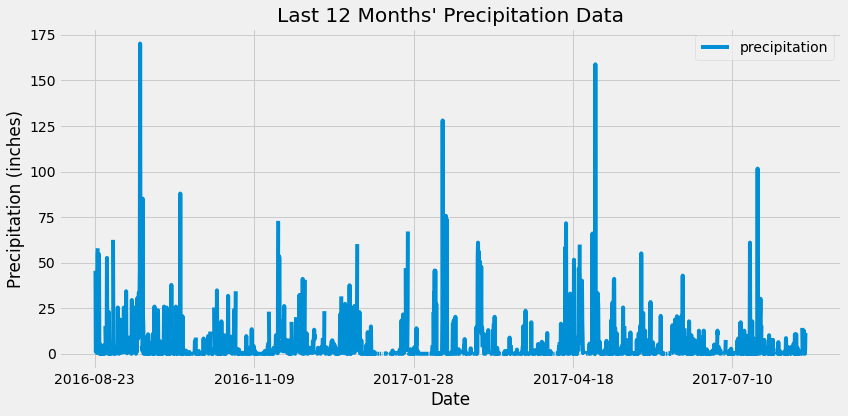

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
last_year_date = (dt.datetime.strptime(latest_date, '%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')


# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= last_year_date).all()


# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['date', 'precipitation'])
df.set_index('date', inplace=True)

# Sort the dataframe by date
df = df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data

fig, ax = plt.subplots(figsize=(12, 6))
df.plot(ax=ax, x_compat=True)
ax.set_xlabel('Date')
ax.set_ylabel('Precipitation (inches)')
ax.set_title("Last 12 Months' Precipitation Data")
plt.tight_layout()
plt.show()


In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary_stats = df['precipitation'].describe()
summary_stats

count    2021.000000
mean        4.505888
std        11.713487
min         0.000000
25%         0.000000
50%         0.500000
75%         3.300000
max       170.200000
Name: precipitation, dtype: float64

# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(func.count(Station.station)).scalar()
print(f"There are {station_count} stations in the dataset.")

There are 9 stations in the dataset.


In [13]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                  group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
print("Most Active Stations:")
for station, count in active_stations:
    print(f"Station {station} had {count} observations.")

Most Active Stations:
Station USC00519281 had 2772 observations.
Station USC00519397 had 2724 observations.
Station USC00513117 had 2709 observations.
Station USC00519523 had 2669 observations.
Station USC00516128 had 2612 observations.
Station USC00514830 had 2202 observations.
Station USC00511918 had 1979 observations.
Station USC00517948 had 1372 observations.
Station USC00518838 had 511 observations.


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]
temp_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
             filter(Measurement.station == most_active_station).all()
             
print(f"Lowest Temperature: {temp_stats[0][0]}")
print(f"Highest Temperature: {temp_stats[0][1]}")
print(f"Average Temperature: {temp_stats[0][2]}")

Lowest Temperature: 12.2
Highest Temperature: 29.4
Average Temperature: 22.03582251082252


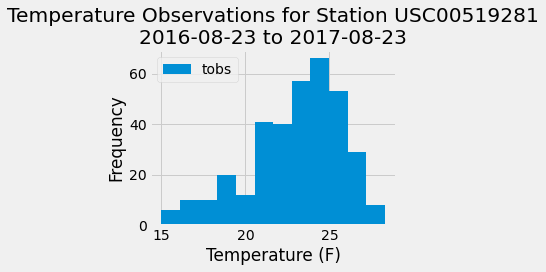

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
last_year_date = (dt.datetime.strptime(latest_date, '%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')

tobs_data = session.query(Measurement.tobs).\
            filter(Measurement.station == most_active_station).\
            filter(Measurement.date >= last_year_date).all()

tobs_df = pd.DataFrame(tobs_data, columns=['tobs'])     

fig, ax = plt.subplots()
tobs_df.plot.hist(bins=12, ax=ax)
ax.set_xlabel("Temperature (F)")
ax.set_ylabel("Frequency")
ax.set_title(f"Temperature Observations for Station {most_active_station}\n{last_year_date} to {latest_date}")
plt.tight_layout()
plt.show()      


# Close session

In [16]:
# Close Session
session.close()